In [65]:
#DEFS

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Gaussian function for peak fitting
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

import numpy as np
import matplotlib.pyplot as plt

def calibrate_axis(x1, x2, channel1, channel2):
    scale_factor = (x2 - x1) / (channel2 - channel1)
    offset = x1 - (channel1 * scale_factor)
    return scale_factor, offset

def read_file(filename):

    # Define calibration values
    x1, x2 =  32, 665.79  #keV
    channel1, channel2 = 16.7, 286
    scale_factor, offset = calibrate_axis(x1, x2, channel1, channel2)

    # Read the file properly
    f = filename

    # Determine header size (try 32 or 64 bytes)
    header_size = 32  # Change this if needed!

    # Read binary file, skipping the header
    with open(f, "rb") as file:
        file.seek(header_size)  # Skip the header
        data = np.fromfile(file, dtype=np.uint32)  # Read spectrum data

    # Ensure no negative or zero values for log scaling
    y_scaled = np.log(data + 1)  # Avoid log(0) errors

    # Compute the scaled x-axis
    channels = np.arange(len(data))
    x_scaled = channels * scale_factor + offset
    
    return(x_scaled, data)


In [66]:
#CESIUM DATA

# Load data for Cs spectra
bkg = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\bkg_spec_longtrace.Chn"
Cs_no_bkg = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Cs137_noBacking_T2.Chn"
Cs_Pb_bkg = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Cs137_PbBacking_T1.Chn"
Cs_Ta_bkg = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Cs137_Ta_Backing_15mins.Chn"

x0,y0 = read_file(bkg)
x1, y1 = read_file(Cs_no_bkg)
x2, y2 = read_file(Cs_Pb_bkg)
x3, y3 = read_file(Cs_Ta_bkg)

def smooth(y):
    for i in range(len(y)):
        if y[i]<=0 :
            y[i] = y[i-1]
    return y

#normalize plot axes
#no backing:
s1 = 900/470 #CHANGE ONCE KNOWN
y1 = y1*s1
#Pb backing:
s2 = 900/590 
y2 = y2*s2
#Ta backing:
s3 = 900/391
y3 = y3*s3
#background trace:
s4 = 900/777.7
y0 = s4*y0
#subtract background
# y1 = y1 - y0
# y2 = y2-y0
# y3 = y3-y0
# smooth(y1)
# smooth(y2)
# smooth(y3)

Peak at 32.0 ± 0.2 keV, FWHM = 18.5 ± 0.6 keV
Peak at 661.9 ± 0.4 keV, FWHM = 67.1 ± 3.2 keV
Gaussian fit failed for peak at 1450.0 keV


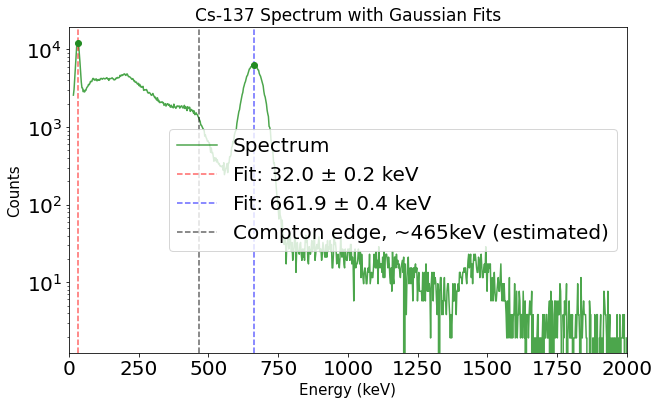

In [67]:
#CESIUM FITS
# Truncate data to 2 MeV and avoid low-energy noise
mask = (x1 > 15) & (x1 < 2000) 
x1 = x1[mask]
y1 = y1[mask]

# Expected peaks for Na-22 (including 1275 keV)
expected_peaks = [32, 662, 1450]
fit_range = 7  # Adjusted for better peak isolation

# Prepare plot
plt.figure(figsize=(10, 6))
plt.plot(x1, y1, label="Spectrum", alpha=0.7, color = 'green')
plt.xlabel("Energy (keV)",fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.title("Cs-137 Spectrum with Gaussian Fits", fontsize = 17)

energies = x1
counts = y1

colors = ['r', 'b']
# Fit Gaussians to each expected peak
i = 0
for peak_energy in expected_peaks:
    peak_index = np.argmin(np.abs(energies - peak_energy))
    
    # Select data around the peak for fitting
    x_fit = energies[max(0, peak_index - fit_range): min(len(energies), peak_index + fit_range)]
    y_fit = counts[max(0, peak_index - fit_range): min(len(counts), peak_index + fit_range)]
    
    # Skip if counts are too low
    if np.max(y_fit) < 10:
        print(f"Skipping {peak_energy:.1f} keV due to low counts")
        continue

    # Initial guess: A = max height, mu = peak position, sigma ~ 5 keV (adjustable)
    p0 = [max(y_fit), peak_energy, 5]  

    try:
        popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
        A_fit, mu_fit, sigma_fit = popt
        uncertainties = np.sqrt(np.diag(pcov))
        mu_uncertainty = uncertainties[1]
        sigma_uncertainty = uncertainties[2]

        # Calculate FWHM
        FWHM = 2.355 * sigma_fit
        FWHM_uncertainty = 2.355 * sigma_uncertainty

        # Round values to 1 decimal place
        mu_fit = round(mu_fit, 1)
        mu_uncertainty = round(mu_uncertainty, 1)
        FWHM = round(FWHM, 1)
        FWHM_uncertainty = round(FWHM_uncertainty, 1)

        # Plot Gaussian fit
        x_smooth = np.linspace(x_fit[0], x_fit[-1], 100)
        #plt.plot(x_smooth, gaussian(x_smooth, *popt), linestyle="--")

        # Print peak information
        print(f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM} ± {FWHM_uncertainty} keV")

        # Mark peak position
        plt.axvline(mu_fit, linestyle="--", color = colors[i], alpha=0.6, label=f"Fit: {mu_fit} ± {mu_uncertainty} keV")
        plt.scatter(mu_fit, gaussian(mu_fit, *popt), color="forestgreen", zorder=3)
        
        i=i+1
    except RuntimeError:
        print(f"Gaussian fit failed for peak at {peak_energy:.1f} keV")

plt.axvline(465, linestyle="--", color="black", alpha=0.6, label = "Compton edge, ~465keV (estimated)")
plt.legend()
plt.yscale("log")
plt.xlim(0, 2000)  # Limit plot to 2 MeV
plt.show()

Peak at 32.0 ± 0.2 keV, FWHM = 18.5 ± 0.6 keV
Peak at 661.9 ± 0.4 keV, FWHM = 67.1 ± 3.2 keV
Gaussian fit failed for peak at 1450.0 keV
Peak at 82.6 ± 0.5 keV, FWHM = 55.6 ± 2.3 keV
Peak at 66.0 ± 2.5 keV, FWHM = 52.6 ± 10.1 keV


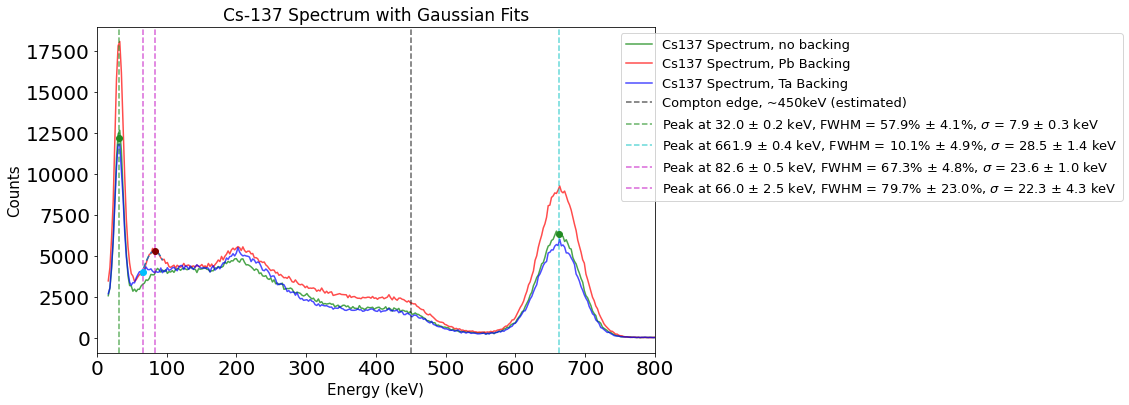

In [86]:
#CESIUM FITS
# Truncate data to 2 MeV and avoid low-energy noise
mask = (x1 > 15) & (x1 < 2000) 
x1 = x1[mask]
y1 = y1[mask]

# Expected peaks for Na-22 (including 1275 keV)
expected_peaks = [32, 662, 1450]
fit_range = 7 # Adjusted for better peak isolation

# Prepare plot
colors = ['g', 'c', 'm']
i=0
plt.figure(figsize=(10, 6))
plt.plot(x1, y1, label="Cs137 Spectrum, no backing", alpha=0.7, color = 'green')
plt.plot(x2, y2, label="Cs137 Spectrum, Pb Backing", alpha=0.7, color = 'red')
plt.plot(x3, y3, label="Cs137 Spectrum, Ta Backing", alpha=0.7, color = 'blue')
plt.axvline(450, linestyle="--", color="black", alpha=0.6, label = "Compton edge, ~450keV (estimated)")
plt.xlabel("Energy (keV)",fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.title("Cs-137 Spectrum with Gaussian Fits", fontsize = 17)

energies = x1
counts = y1

# Fit Gaussians to each expected peak
for peak_energy in expected_peaks:
    peak_index = np.argmin(np.abs(energies - peak_energy))
    
    # Select data around the peak for fitting
    x_fit = energies[max(0, peak_index - fit_range): min(len(energies), peak_index + fit_range)]
    y_fit = counts[max(0, peak_index - fit_range): min(len(counts), peak_index + fit_range)]
    
    # Skip if counts are too low
    if np.max(y_fit) < 10:
        print(f"Skipping {peak_energy:.1f} keV due to low counts")
        continue

    # Initial guess: A = max height, mu = peak position, sigma ~ 5 keV (adjustable)
    p0 = [max(y_fit), peak_energy, 5]  

    try:
        popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
        A_fit, mu_fit, sigma_fit = popt
        uncertainties = np.sqrt(np.diag(pcov))
        mu_uncertainty = uncertainties[1]
        sigma_uncertainty = uncertainties[2]

        # Calculate FWHM
        FWHM = 2.355 * sigma_fit
        FWHM_uncertainty = 2.355 * sigma_uncertainty
        
        FWHM_pc = (FWHM/mu_fit)*100
        FWHM_pc = round(FWHM_pc, 1)
        FWHM_pc_uncertainty = (mu_uncertainty/mu_fit + FWHM_uncertainty/FWHM)*100
        FWHM_pc_uncertainty = round(FWHM_pc_uncertainty, 1)
        sigma_fit = round(sigma_fit, 1)
        sfit_uncertainty = round(sigma_uncertainty, 1)
        
        # Round values to 1 decimal place
        mu_fit = round(mu_fit, 1)
        mu_uncertainty = round(mu_uncertainty, 1)
        FWHM = round(FWHM, 1)
        FWHM_uncertainty = round(FWHM_uncertainty, 1)

        # Plot Gaussian fit
        x_smooth = np.linspace(x_fit[0], x_fit[-1], 100)
        #plt.plot(x_smooth, gaussian(x_smooth, *popt), linestyle="--", label=f"Fit: {mu_fit} ± {mu_uncertainty} keV")

        # Print peak information
        print(f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM} ± {FWHM_uncertainty} keV")

        # Mark peak position
        #plt.axvline(mu_fit, linestyle="--", color=colors[i], alpha=0.6,  label=f"Fit: {mu_fit} ± {mu_uncertainty} keV; FWHM: {FWHM} ± {FWHM_uncertainty} keV")
        plt.axvline(mu_fit, linestyle="--", alpha=0.6,color = colors[i], label=f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM_pc}% ± {FWHM_pc_uncertainty}%, $\sigma$ = {sigma_fit} ± {sfit_uncertainty} keV")
        plt.scatter(mu_fit, gaussian(mu_fit, *popt), color="forestgreen", zorder=3)
        i=i+1

    except RuntimeError:
        print(f"Gaussian fit failed for peak at {peak_energy:.1f} keV")

#plt.yscale("log")
plt.xlim(0, 2000)  # Limit plot to 2 MeV

# Truncate data to 2 MeV and avoid low-energy noise
mask = (x2 > 15) & (x2 < 2000) 
x2 = x2[mask]
y2 = y2[mask]

mask = (x3 > 15) & (x3 < 2000) 
x3 = x3[mask]
y3 = y3[mask]
# Expected peaks for Na-22 (including 1275 keV)
expected_peaks = [80]
fit_range = 7  # Adjusted for better peak isolation

# Prepare plot
plt.xlabel("Energy (keV)",fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.title("Cs-137 Spectrum with Gaussian Fits", fontsize = 17)
energies = x2
counts = y2

# Fit Gaussians to each expected peak
for peak_energy in expected_peaks:
    peak_index = np.argmin(np.abs(energies - peak_energy))
    
    # Select data around the peak for fitting
    x_fit = energies[max(0, peak_index - fit_range): min(len(energies), peak_index + fit_range)]
    y_fit = counts[max(0, peak_index - fit_range): min(len(counts), peak_index + fit_range)]
    
    # Skip if counts are too low
    if np.max(y_fit) < 10:
        print(f"Skipping {peak_energy:.1f} keV due to low counts")
        continue

    # Initial guess: A = max height, mu = peak position, sigma ~ 5 keV (adjustable)
    p0 = [max(y_fit), peak_energy, 7]  

    try:
        popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
        A_fit, mu_fit, sigma_fit = popt
        uncertainties = np.sqrt(np.diag(pcov))
        mu_uncertainty = uncertainties[1]
        sigma_uncertainty = uncertainties[2]

        # Calculate FWHM
        FWHM = 2.355 * sigma_fit
        FWHM_uncertainty = 2.355 * sigma_uncertainty
        
        FWHM_pc = (FWHM/mu_fit)*100
        FWHM_pc = round(FWHM_pc, 1)
        FWHM_pc_uncertainty = (mu_uncertainty/mu_fit + FWHM_uncertainty/FWHM)*100
        FWHM_pc_uncertainty = round(FWHM_pc_uncertainty, 1)
        sigma_fit = round(sigma_fit, 1)
        sfit_uncertainty = round(sigma_uncertainty, 1)

        # Round values to 1 decimal place
        mu_fit = round(mu_fit, 1)
        mu_uncertainty = round(mu_uncertainty, 1)
        FWHM = round(FWHM, 1)
        FWHM_uncertainty = round(FWHM_uncertainty, 1)

        # Plot Gaussian fit
        x_smooth = np.linspace(x_fit[0], x_fit[-1], 100)
        plt.plot(x_smooth, gaussian(x_smooth, *popt), linestyle="--")

        # Print peak information
        print(f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM} ± {FWHM_uncertainty} keV")

        # Mark peak position
        #plt.axvline(mu_fit, linestyle="--", color="red", label=f"Pb peak: {mu_fit} ± {mu_uncertainty} keV; FWHM: {FWHM} ± {FWHM_uncertainty} keV", alpha=0.6)
        plt.axvline(mu_fit, linestyle="--", alpha=0.6,color = colors[i], label=f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM_pc}% ± {FWHM_pc_uncertainty}%, $\sigma$ = {sigma_fit} ± {sfit_uncertainty} keV")
        plt.scatter(mu_fit, gaussian(mu_fit, *popt), color="maroon", zorder=3)

    except RuntimeError:
        print(f"Gaussian fit failed for peak at {peak_energy:.1f} keV")

# Expected peaks for Na-22 (including 1275 keV)
expected_peaks = [60]
fit_range = 4  # Adjusted for better peak isolation

# Prepare plot
energies = x3
counts = y3

# Fit Gaussians to each expected peak
for peak_energy in expected_peaks:
    peak_index = np.argmin(np.abs(energies - peak_energy))
    
    # Select data around the peak for fitting
    x_fit = energies[max(0, peak_index - fit_range): min(len(energies), peak_index + fit_range)]
    y_fit = counts[max(0, peak_index - fit_range): min(len(counts), peak_index + fit_range)]
    
    # Skip if counts are too low
    if np.max(y_fit) < 10:
        print(f"Skipping {peak_energy:.1f} keV due to low counts")
        continue

    # Initial guess: A = max height, mu = peak position, sigma ~ 5 keV (adjustable)
    p0 = [max(y_fit), peak_energy, 5]  

    try:
        popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
        A_fit, mu_fit, sigma_fit = popt
        uncertainties = np.sqrt(np.diag(pcov))
        mu_uncertainty = uncertainties[1]
        sigma_uncertainty = uncertainties[2]

        # Calculate FWHM
        FWHM = 2.355 * sigma_fit
        FWHM_uncertainty = 2.355 * sigma_uncertainty
        
        FWHM_pc = (FWHM/mu_fit)*100
        FWHM_pc = round(FWHM_pc, 1)
        FWHM_pc_uncertainty = (mu_uncertainty/mu_fit + FWHM_uncertainty/FWHM)*100
        FWHM_pc_uncertainty = round(FWHM_pc_uncertainty, 1)
        sigma_fit = round(sigma_fit, 1)
        sfit_uncertainty = round(sigma_uncertainty, 1)
        
        # Round values to 1 decimal place
        mu_fit = round(mu_fit, 1)
        mu_uncertainty = round(mu_uncertainty, 1)
        FWHM = round(FWHM, 1)
        FWHM_uncertainty = round(FWHM_uncertainty, 1)

        # Plot Gaussian fit
        x_smooth = np.linspace(x_fit[0], x_fit[-1], 100)
        #plt.plot(x_smooth, gaussian(x_smooth, *popt), linestyle="--")

        # Print peak information
        print(f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM} ± {FWHM_uncertainty} keV")

        # Mark peak position
        #plt.axvline(mu_fit, linestyle="--", color='b', label=f"Ta Peak: {mu_fit} ± {mu_uncertainty} keV; FWHM: {FWHM} ± {FWHM_uncertainty} keV", alpha=0.6)
        plt.axvline(mu_fit, linestyle="--", alpha=0.6,color = colors[i], label=f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM_pc}% ± {FWHM_pc_uncertainty}%, $\sigma$ = {sigma_fit} ± {sfit_uncertainty} keV")
        plt.scatter(mu_fit, gaussian(mu_fit, *popt), color="deepskyblue", zorder=3)
        i=i+1
    except RuntimeError:
        print(f"Gaussian fit failed for peak at {peak_energy:.1f} keV")

plt.legend(bbox_to_anchor=(1.85, 1), loc='upper right', prop={'size': 13})
plt.xlim(0,800)
plt.show()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Peak at 516.7 ± 1.1 keV, FWHM = 68.5 ± 2.7 keV
Peak at 1281.2 ± 4.0 keV, FWHM = 111.9 ± 12.3 keV
Skipping 1470.0 keV due to low counts


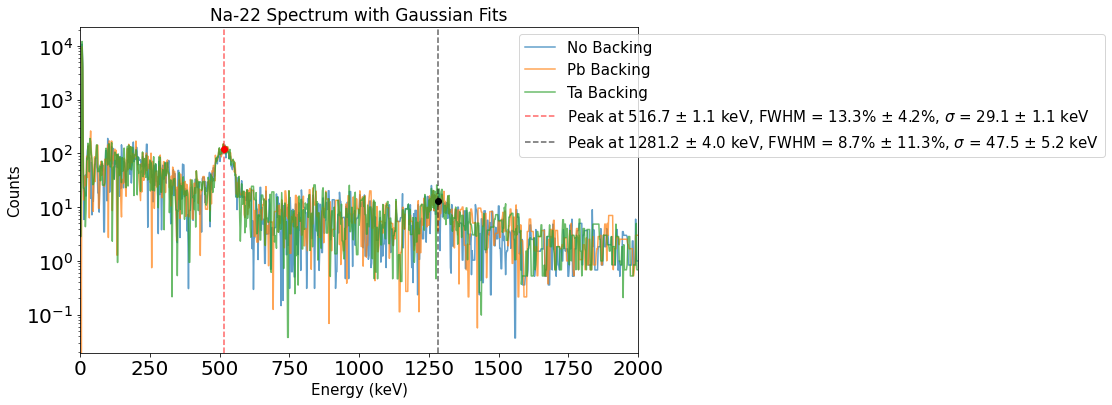

In [61]:
#SODIUM FITS

#import data
bkg = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\bkg_spec_longtrace.Chn"
Na_no_bkg = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\na22_nobacking_logplt.Chn"
Na_Pb_bkg = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Na22_Pbbacking.Chn"
Na_Ta_bkg = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Na22_Tabacking_logplt.Chn"

x0,y0 = read_file(bkg)
print(type(y0))
x1, y1 = read_file(Na_no_bkg)
print(type(y1))
x2, y2 = read_file(Na_Pb_bkg)
x3, y3 = read_file(Na_Ta_bkg)

def smooth(y):
    for i in range(len(y)):
        if (y[i]<=0):
            y[i] = y[i-1]
    return(y)
           
            
#normalize plot axes
#no backing:
s1 = 900/902.54 #CHANGE ONCE KNOWN
y1 = y1*s1
print(type(y1))
#Pb backing:
s2 = 900/900
#y2 = np.log(y2)
y2 = y2*s2
#Ta backing:
s3 = 900/900.96
y3 = y3*s3
#background trace:
s4 = 900/777.7
y0 = s4*y0
#subtract background
y1 = y1 - y0
y2 = y2-y0
y3 = y3-y0
y1 = smooth(y1)
y2 = smooth(y2)
y3 = smooth(y3)


# Expected peaks for Na-22 (including 1275 keV)
expected_peaks = [511, 1274, 1470]
fit_range = 30  # Adjusted for better peak isolation

# Prepare plot
plt.figure(figsize=(10, 6))
plt.plot(x1, y1, label="No Backing", alpha=0.7)
plt.plot(x2, y2, label="Pb Backing", alpha=0.7)
plt.plot(x3, y3, label="Ta Backing", alpha=0.7)
plt.xlabel("Energy (keV)",fontsize = 15)
plt.ylabel("Counts", fontsize = 15)
plt.title("Na-22 Spectrum with Gaussian Fits", fontsize = 17)


print(type(y1))
# Truncate data to 2 MeV and avoid low-energy noise
mask = (x1 > 15) & (x1 < 2000) 
print(type(y1))
x1 = x1[mask]
print(type(y1))

energies = x2
counts = y2
colors = ['r', 'k']
i = 0
# Fit Gaussians to each expected peak
for peak_energy in expected_peaks:
    peak_index = np.argmin(np.abs(energies - peak_energy))
    
    # Select data around the peak for fitting
    x_fit = energies[max(0, peak_index - fit_range): min(len(energies), peak_index + fit_range)]
    y_fit = counts[max(0, peak_index - fit_range): min(len(counts), peak_index + fit_range)]
    
    # Skip if counts are too low
    if np.max(y_fit) < 10:
        print(f"Skipping {peak_energy:.1f} keV due to low counts")
        continue

    # Initial guess: A = max height, mu = peak position, sigma ~ 5 keV (adjustable)
    p0 = [max(y_fit), peak_energy, 5]  

    try:
        popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
        A_fit, mu_fit, sigma_fit = popt
        uncertainties = np.sqrt(np.diag(pcov))
        mu_uncertainty = uncertainties[1]
        sigma_uncertainty = uncertainties[2]

        # Calculate FWHM
        FWHM = 2.355 * sigma_fit
        FWHM_uncertainty = 2.355 * sigma_uncertainty
        
        FWHM_pc = (FWHM/mu_fit)*100
        FWHM_pc = round(FWHM_pc, 1)
        FWHM_pc_uncertainty = (mu_uncertainty/mu_fit + FWHM_uncertainty/FWHM)*100
        FWHM_pc_uncertainty = round(FWHM_pc_uncertainty, 1)

        # Round values to 1 decimal place
        mu_fit = round(mu_fit, 1)
        mu_uncertainty = round(mu_uncertainty, 1)
        FWHM = round(FWHM, 1)
        FWHM_uncertainty = round(FWHM_uncertainty, 1)
        sigma_fit = round(sigma_fit, 1)
        sfit_uncertainty = round(sigma_uncertainty, 1)

        # Plot Gaussian fit
        x_smooth = np.linspace(x_fit[0], x_fit[-1], 100)
        #plt.plot(x_smooth, gaussian(x_smooth, *popt), linestyle="--", label=f"Fit:{mu_fit} ± {mu_uncertainty} keV; FWHM: {FWHM} ± {FWHM_uncertainty} keV")

        # Print peak information
        print(f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM} ± {FWHM_uncertainty} keV")

        # Mark peak position
        plt.axvline(mu_fit, linestyle="--", alpha=0.6,color = colors[i], label=f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM_pc}% ± {FWHM_pc_uncertainty}%, $\sigma$ = {sigma_fit} ± {sfit_uncertainty} keV")
        plt.scatter(mu_fit, gaussian(mu_fit, *popt), color=colors[i], zorder=3)
        i = i+1
    except RuntimeError:
        print(f"Gaussian fit failed for peak at {peak_energy:.1f} keV")

plt.rcParams.update({'font.size': 20})
plt.legend(bbox_to_anchor=(1.85, 1), loc='upper right', prop={'size': 15})
plt.yscale("log")
plt.xlim(0, 2000)  # Limit plot to 2 MeV
plt.show()


Peak at 1179.8 ± 1.9 keV, FWHM = 6.9 ± 7.7 keV, $\sigma$ = 34.8 ± 2.6
Peak at 1346.8 ± 7.4 keV, FWHM = 10.0 ± 21.0 keV, $\sigma$ = 57.2 ± 11.7


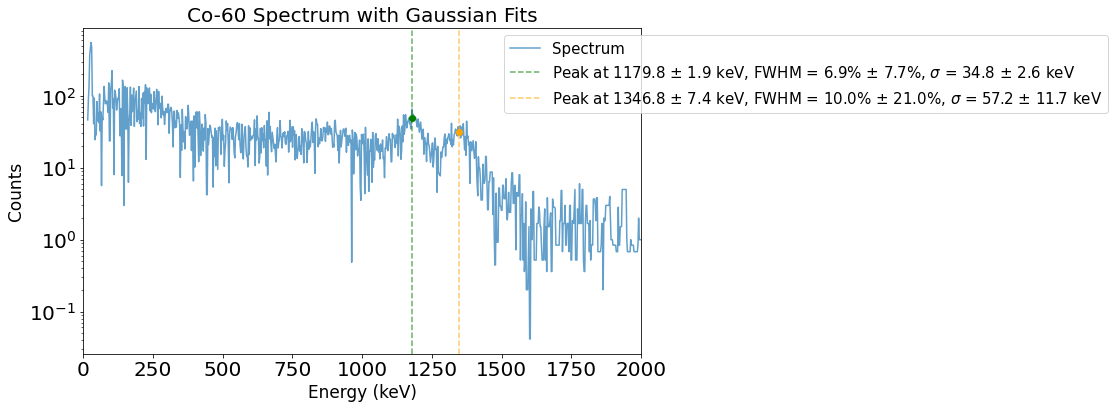

In [58]:
#COBALT FITS

#import data
bkg = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\bkg_spec_longtrace.Chn"
Co_no_bkg = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Co60_nobacking_shield.Chn"
Co_Pb_bkg = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\co_Pb_backing.Chn"
Co_Ta_bkg = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Co60_Tabacking_logplt.Chn"

x0,y0 = read_file(bkg)
x1, y1 = read_file(Co_no_bkg)
x2, y2 = read_file(Co_Pb_bkg)
x3, y3 = read_file(Co_Ta_bkg)
colors = ['g', 'orange']
i = 0
def smooth(y):
    for i in range(len(y)):
        if y[i]<=0 :
            y[i] = y[i-1]
    return y
#normalize plot axes
#no backing:
s1 = 900/839.88
y1 = y1*s1
#Pb backing:
s2 = 900/901.92
#y2 = np.log(y2)
y2 = y2*s2
#Ta backing:
s3 = 900/838.38
y3 = y3*s3
#background trace:
s4 = 900/777.7
y0 = s4*y0
#subtract background
y1 = y1 - y0
y2 = y2-y0
y3 = y3-y0
y1 = smooth(y1)
y2 = smooth(y2)
y3 = smooth(y3)

# Truncate data to 2 MeV and avoid low-energy noise
mask = (x2 > 15) & (x2 < 2000) 
x2 = x2[mask]
y2 = y2[mask]

# Expected peaks for Na-22 (including 1275 keV)
expected_peaks = [1186, 1332.5]
fit_range = 20  # Adjusted for better peak isolation

# Prepare plot
plt.figure(figsize=(10, 6))
plt.plot(x2, y2, label="Spectrum", alpha=0.7)
plt.xlabel("Energy (keV)",fontsize = 17)
plt.ylabel("Counts", fontsize = 17)
plt.title("Co-60 Spectrum with Gaussian Fits", fontsize = 20)

energies = x2
counts = y2

# Fit Gaussians to each expected peak
for peak_energy in expected_peaks:
    peak_index = np.argmin(np.abs(energies - peak_energy))
    
    # Select data around the peak for fitting
    x_fit = energies[max(0, peak_index - fit_range): min(len(energies), peak_index + fit_range)]
    y_fit = counts[max(0, peak_index - fit_range): min(len(counts), peak_index + fit_range)]
    
    # Skip if counts are too low
    if np.max(y_fit) < 10:
        print(f"Skipping {peak_energy:.1f} keV due to low counts")
        continue

    # Initial guess: A = max height, mu = peak position, sigma ~ 5 keV (adjustable)
    p0 = [max(y_fit), peak_energy, 5]  

    try:
        popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
        A_fit, mu_fit, sigma_fit = popt
        uncertainties = np.sqrt(np.diag(pcov))
        mu_uncertainty = uncertainties[1]
        sigma_uncertainty = uncertainties[2]

        # Calculate FWHM
        FWHM = 2.355 * sigma_fit
        FWHM_uncertainty = 2.355 * sigma_uncertainty
        
        FWHM_pc = (FWHM/mu_fit)*100
        FWHM_pc = round(FWHM_pc, 1)
        FWHM_pc_uncertainty = (mu_uncertainty/mu_fit + FWHM_uncertainty/FWHM)*100
        FWHM_pc_uncertainty = round(FWHM_pc_uncertainty, 1)

        # Round values to 1 decimal place
        mu_fit = round(mu_fit, 1)
        mu_uncertainty = round(mu_uncertainty, 1)
        FWHM = round(FWHM, 1)
        FWHM_uncertainty = round(FWHM_uncertainty, 1)
        sigma_fit = round(sigma_fit, 1)
        sfit_uncertainty = round(sigma_uncertainty, 1)
        
        
        # Plot Gaussian fit
        x_smooth = np.linspace(x_fit[0], x_fit[-1], 100)
        #plt.plot(x_smooth, gaussian(x_smooth, *popt), linestyle="--", label=f"Fit: {mu_fit} ± {mu_uncertainty} keV")

        # Print peak information
        print(f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM_pc} ± {FWHM_pc_uncertainty} keV, $\sigma$ = {sigma_fit} ± {sfit_uncertainty}")

        # Mark peak position
        plt.axvline(mu_fit, linestyle="--", color=colors[i], alpha=0.6, label=f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM_pc}% ± {FWHM_pc_uncertainty}%, $\sigma$ = {sigma_fit} ± {sfit_uncertainty} keV")
        plt.scatter(mu_fit, gaussian(mu_fit, *popt), color=colors[i], zorder=3)
        i = i+1
    except RuntimeError:
        print(f"Gaussian fit failed for peak at {peak_energy:.1f} keV")

plt.legend(bbox_to_anchor=(1.85, 1), loc='upper right', prop={'size': 15})
plt.yscale("log")
plt.xlim(0, 2000)  # Limit plot to 2 MeV
plt.show()


In [72]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

def plot_all_spectra():
    # --------- Cs-137 Block -------------
    # (Assumes x1,y1, x2,y2, x3,y3 for Cs-137 are defined previously.)
    # Truncate data to 2 MeV and avoid low-energy noise:
    mask1 = (x1 > 15) & (x1 < 2000)
    x1_c = x1[mask1]
    y1_c = y1[mask1]

    mask2 = (x2 > 15) & (x2 < 2000)
    x2_c = x2[mask2]
    y2_c = y2[mask2]

    mask3 = (x3 > 15) & (x3 < 2000)
    x3_c = x3[mask3]
    y3_c = y3[mask3]

    # --------- Na-22 Block -------------
    # File paths (adjust these as needed)
    bkg_path   = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\bkg_spec_longtrace.Chn"
    Na_nb_path = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\na22_nobacking_logplt.Chn"
    Na_Pb_path = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Na22_Pbbacking.Chn"
    Na_Ta_path = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Na22_Tabacking_logplt.Chn"
    
    # Load the data (assumes your read_file returns numpy arrays: x, y)
    x0_n, y0_n = read_file(bkg_path)
    x1_n, y1_n = read_file(Na_nb_path)
    x2_n, y2_n = read_file(Na_Pb_path)
    x3_n, y3_n = read_file(Na_Ta_path)
    
    def smooth(y):
        y = np.array(y, dtype=float)
        for i in range(1, len(y)):
            if y[i] <= 0:
                y[i] = y[i-1]
        return y

    # Normalize each spectrum and subtract background:
    s1 = 900/902.54
    y1_n = y1_n * s1
    s2 = 900/900
    y2_n = y2_n * s2
    s3 = 900/900.96
    y3_n = y3_n * s3
    s4 = 900/777.7
    y0_n = s4 * y0_n

    y1_n = smooth(y1_n - y0_n)
    y2_n = smooth(y2_n - y0_n)
    y3_n = smooth(y3_n - y0_n)
    
    mask_n = (x1_n > 15) & (x1_n < 2000)
    x1_n = x1_n[mask_n]
    y1_n = y1_n[mask_n]

    # --------- Co-60 Block -------------
    Co_bkg_path   = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\bkg_spec_longtrace.Chn"
    Co_nb_path    = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Co60_nobacking_shield.Chn"
    Co_Pb_path    = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\co_Pb_backing.Chn"
    Co_Ta_path    = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Co60_Tabacking_logplt.Chn"
    
    x0_c, y0_c = read_file(Co_bkg_path)
    x1_c, y1_c = read_file(Co_nb_path)
    x2_c, y2_c = read_file(Co_Pb_path)
    x3_c, y3_c = read_file(Co_Ta_path)
    
    s1c = 900/839.88
    y1_c = y1_c * s1c
    s2c = 900/901.92
    y2_c = y2_c * s2c
    s3c = 900/838.38
    y3_c = y3_c * s3c
    s4c = 900/777.7
    y0_c = s4c * y0_c
    
    y1_c = smooth(y1_c - y0_c)
    y2_c = smooth(y2_c - y0_c)
    y3_c = smooth(y3_c - y0_c)
    
    mask_c = (x2_c > 15) & (x2_c < 2000)
    x2_c = x2_c[mask_c]
    y2_c = y2_c[mask_c]
    
    # --------- Create Subplots -------------
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    
    # ----- Subplot 1: Cs-137 -----
    ax = axs[0]
    cs_colors = ['green','red','blue']
    ax.plot(x1_c, y1_c, label="Cs137, no backing", alpha=0.7, color='green')
    ax.plot(x2_c, y2_c, label="Cs137, Pb Backing", alpha=0.7, color='red')
    ax.plot(x3_c, y3_c, label="Cs137, Ta Backing", alpha=0.7, color='blue')
    ax.axvline(411, linestyle="--", color="black", alpha=0.6,
               label="Compton edge, ~411 keV (est.)")
    ax.set_xlabel("Energy (keV)", fontsize=15)
    ax.set_ylabel("Counts", fontsize=15)
    ax.set_title("Cs-137 Spectrum with Gaussian Fits", fontsize=17)
    
    # --- Fit Gaussians for Cs-137 ---
    # Using x1_c, y1_c with expected peaks: [32, 662, 1450]
    expected_peaks = [32, 662, 1450]
    fit_range = 7
    for i, peak in enumerate(expected_peaks):
        idx = np.argmin(np.abs(x1_c - peak))
        x_fit = x1_c[max(0, idx - fit_range): min(len(x1_c), idx + fit_range)]
        y_fit = y1_c[max(0, idx - fit_range): min(len(y1_c), idx + fit_range)]
        if np.max(y_fit) < 10:
            print(f"Skipping {peak} keV due to low counts")
            continue
        p0 = [max(y_fit), peak, 5]
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            A_fit, mu_fit, sigma_fit = popt
            uncert = np.sqrt(np.diag(pcov))
            FWHM = round(2.355 * sigma_fit, 1)
            mu_fit = round(mu_fit, 1)
            mu_unc = round(uncert[1], 1)
            ax.axvline(mu_fit, linestyle="--", color=cs_colors[i],
                       alpha=0.6,
                       label=f"Fit: {mu_fit}±{mu_unc} keV; FWHM: {FWHM} keV")
            ax.scatter(mu_fit, gaussian(mu_fit, *popt), color="forestgreen", zorder=3)
        except RuntimeError:
            print(f"Gaussian fit failed for {peak} keV")
    ax.set_xlim(0, 800)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=10)
    
    # ----- Subplot 2: Na-22 -----
    ax = axs[1]
    ax.plot(x1_n, y1_n, label="No Backing", alpha=0.7)
    ax.plot(x2_n, y2_n, label="Pb Backing", alpha=0.7)
    ax.plot(x3_n, y3_n, label="Ta Backing", alpha=0.7)
    ax.set_xlabel("Energy (keV)", fontsize=15)
    ax.set_ylabel("Counts", fontsize=15)
    ax.set_title("Na-22 Spectrum with Gaussian Fits", fontsize=17)
    
    expected_peaks_n = [511, 1274, 1470]
    fit_range = 30
    na_colors = ['r', 'k']  # alternate colors for fits
    for i, peak in enumerate(expected_peaks_n):
        idx = np.argmin(np.abs(x2_n - peak))
        x_fit = x2_n[max(0, idx - fit_range): min(len(x2_n), idx + fit_range)]
        y_fit = y2_n[max(0, idx - fit_range): min(len(y2_n), idx + fit_range)]
        if np.max(y_fit) < 10:
            print(f"Skipping {peak} keV due to low counts")
            continue
        p0 = [max(y_fit), peak, 5]
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            uncert = np.sqrt(np.diag(pcov))
            FWHM = 2.355 * popt[2]
            FWHM_pc = round((FWHM/popt[1])*100, 1)
            mu_fit = round(popt[1], 1)
            mu_unc = round(uncert[1], 1)
            FWHM = round(FWHM, 1)
            ax.axvline(mu_fit, linestyle="--", alpha=0.6,
                       color=na_colors[i % len(na_colors)],
                       label=f"Peak: {mu_fit}±{mu_unc} keV; FWHM: {FWHM_pc}%")
            ax.scatter(mu_fit, gaussian(mu_fit, *popt),
                       color=na_colors[i % len(na_colors)], zorder=3)
        except RuntimeError:
            print(f"Gaussian fit failed for {peak} keV")
    ax.set_yscale("log")
    ax.set_xlim(0, 2000)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=10)
    
    # ----- Subplot 3: Co-60 -----
    ax = axs[2]
    ax.plot(x2_c, y2_c, label="Spectrum", alpha=0.7)
    ax.set_xlabel("Energy (keV)", fontsize=17)
    ax.set_ylabel("Counts", fontsize=17)
    ax.set_title("Co-60 Spectrum with Gaussian Fits", fontsize=20)
    
    expected_peaks_c = [1186, 1332.5]
    fit_range = 20
    co_colors = ['g', 'orange']
    for i, peak in enumerate(expected_peaks_c):
        idx = np.argmin(np.abs(x2_c - peak))
        x_fit = x2_c[max(0, idx - fit_range): min(len(x2_c), idx + fit_range)]
        y_fit = y2_c[max(0, idx - fit_range): min(len(y2_c), idx + fit_range)]
        if np.max(y_fit) < 10:
            print(f"Skipping {peak} keV due to low counts")
            continue
        p0 = [max(y_fit), peak, 5]
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            uncert = np.sqrt(np.diag(pcov))
            FWHM = 2.355 * popt[2]
            FWHM_pc = round((FWHM/popt[1])*100, 1)
            mu_fit = round(popt[1], 1)
            mu_unc = round(uncert[1], 1)
            FWHM = round(FWHM, 1)
            ax.axvline(mu_fit, linestyle="--", color=co_colors[i],
                       alpha=0.6,
                       label=f"Peak: {mu_fit}±{mu_unc} keV; FWHM: {FWHM_pc}%")
            ax.scatter(mu_fit, gaussian(mu_fit, *popt),
                       color=co_colors[i], zorder=3)
        except RuntimeError:
            print(f"Gaussian fit failed for {peak} keV")
    ax.set_yscale("log")
    ax.set_xlim(0, 2000)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fontsize=10)
    
    plt.tight_layout()
    plt.show()

# To run the function, ensure that:
# 1. The variables (x1,y1, x2,y2, x3,y3) for the Cs-137 block are already defined.
# 2. The helper function read_file is defined and returns numpy arrays.
#
# Then simply call:
# plot_all_spectra()


Gaussian fit failed for 1450 keV
Skipping 1470 keV due to low counts


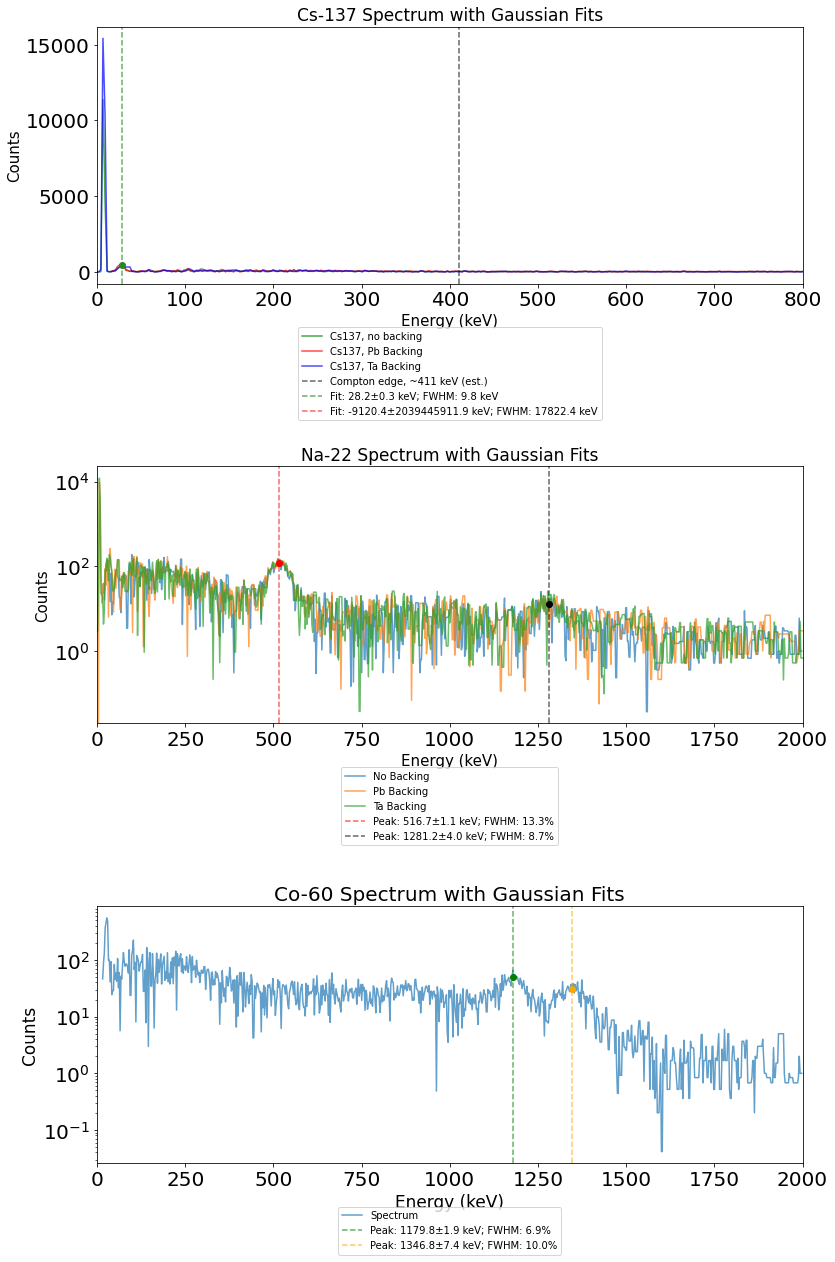

In [73]:
plot_all_spectra()

Gaussian fit failed for 1450 keV
Skipping 1470 keV due to low counts


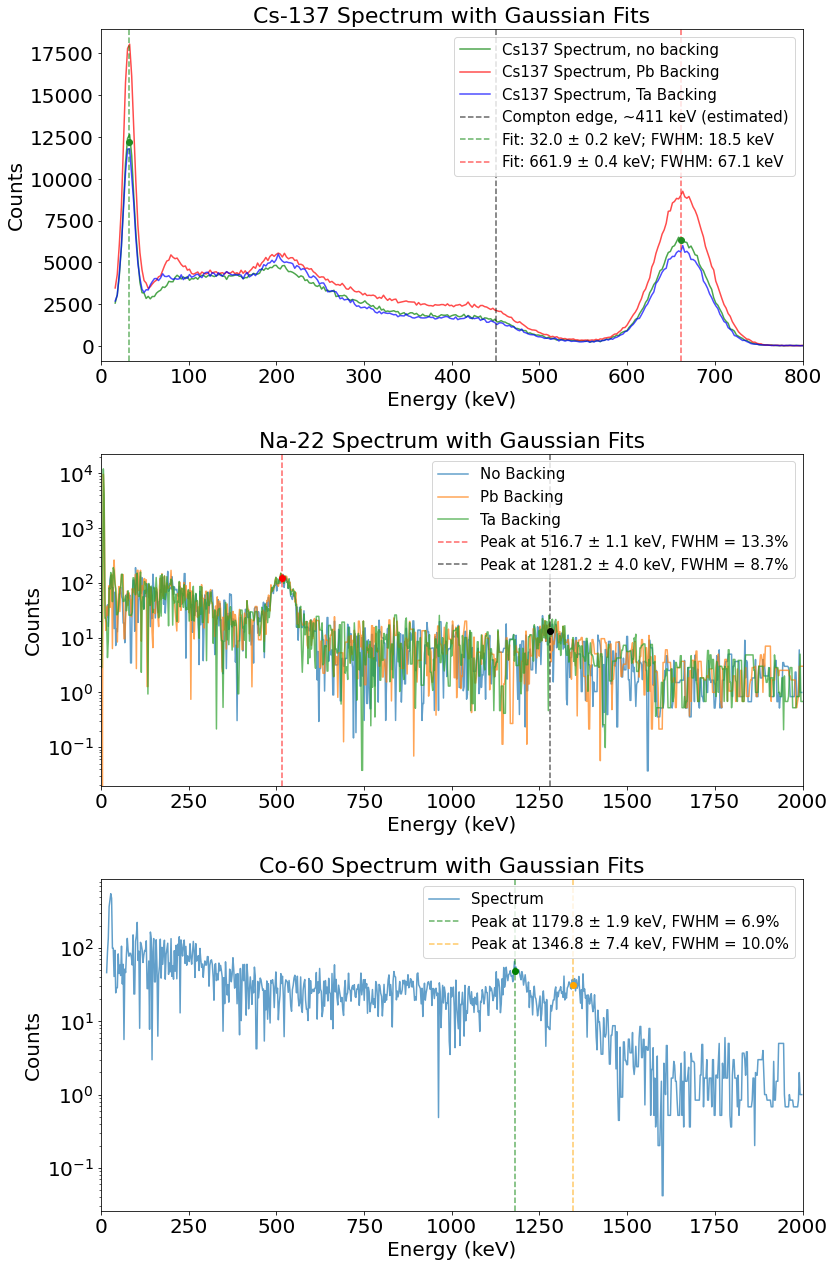

In [91]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

def plot_all_spectra():
    # ------------- Cs-137 Block -------------
    # (Assumes x1, y1, x2, y2, x3, y3 are defined prior to calling this function.)
    # Truncate data to 2 MeV and avoid low-energy noise:
    mask_cs1 = (x1 > 15) & (x1 < 2000)
    x1_cs = x1[mask_cs1]
    y1_cs = y1[mask_cs1]
    
    mask_cs2 = (x2 > 15) & (x2 < 2000)
    x2_cs = x2[mask_cs2]
    y2_cs = y2[mask_cs2]
    
    mask_cs3 = (x3 > 15) & (x3 < 2000)
    x3_cs = x3[mask_cs3]
    y3_cs = y3[mask_cs3]
    
    # ------------- Na-22 Block -------------
    # Define file paths (update these paths as needed)
    bkg_path   = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\bkg_spec_longtrace.Chn"
    Na_nb_path = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\na22_nobacking_logplt.Chn"
    Na_Pb_path = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Na22_Pbbacking.Chn"
    Na_Ta_path = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Na22_Tabacking_logplt.Chn"
    
    # Load data (read_file should return numpy arrays for x and y)
    x0_n, y0_n = read_file(bkg_path)
    x1_n, y1_n = read_file(Na_nb_path)
    x2_n, y2_n = read_file(Na_Pb_path)
    x3_n, y3_n = read_file(Na_Ta_path)
    
    def smooth(y):
        y = np.array(y, dtype=float)
        for i in range(1, len(y)):
            if y[i] <= 0:
                y[i] = y[i-1]
        return y

    # Normalize and subtract background:
    s1 = 900/902.54
    y1_n = y1_n * s1
    s2 = 900/900
    y2_n = y2_n * s2
    s3 = 900/900.96
    y3_n = y3_n * s3
    s4 = 900/777.7
    y0_n = y0_n * s4
    
    y1_n = smooth(y1_n - y0_n)
    y2_n = smooth(y2_n - y0_n)
    y3_n = smooth(y3_n - y0_n)
    
    # Truncate Na-22 data:
    mask_na = (x1_n > 15) & (x1_n < 2000)
    x1_n = x1_n[mask_na]
    y1_n = y1_n[mask_na]
    
    # ------------- Co-60 Block -------------
    # Define file paths (update these paths as needed)
    Co_bkg_path = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\bkg_spec_longtrace.Chn"
    Co_nb_path  = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Co60_nobacking_shield.Chn"
    Co_Pb_path  = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\co_Pb_backing.Chn"
    Co_Ta_path  = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Co60_Tabacking_logplt.Chn"
    
    x0_c, y0_c = read_file(Co_bkg_path)
    x1_c, y1_c = read_file(Co_nb_path)
    x2_c, y2_c = read_file(Co_Pb_path)
    x3_c, y3_c = read_file(Co_Ta_path)
    
    s1c = 900/839.88
    y1_c = y1_c * s1c
    s2c = 900/901.92
    y2_c = y2_c * s2c
    s3c = 900/838.38
    y3_c = y3_c * s3c
    s4c = 900/777.7
    y0_c = y0_c * s4c
    
    y1_c = smooth(y1_c - y0_c)
    y2_c = smooth(y2_c - y0_c)
    y3_c = smooth(y3_c - y0_c)
    
    # Truncate Co-60 data (using the Pb-backed spectrum for fitting)
    mask_c = (x2_c > 15) & (x2_c < 2000)
    x2_c = x2_c[mask_c]
    y2_c = y2_c[mask_c]
    
    # ------------- Create Subplots -------------
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    
    # ----- Subplot 1: Cs-137 -----
    ax = axs[0]
    # Plot spectra
    ax.plot(x1_cs, y1_cs, label="Cs137 Spectrum, no backing", alpha=0.7, color='green')
    ax.plot(x2_cs, y2_cs, label="Cs137 Spectrum, Pb Backing", alpha=0.7, color='red')
    ax.plot(x3_cs, y3_cs, label="Cs137 Spectrum, Ta Backing", alpha=0.7, color='blue')
    # Compton edge line
    ax.axvline(450, linestyle="--", color="black", alpha=0.6, label="Compton edge, ~411 keV (estimated)")
    
    # Fit Gaussians for expected Cs-137 peaks (using the no-backing spectrum as an example)
    expected_peaks_cs = [32, 662, 1450]
    fit_range = 7
    cs_colors = ['green', 'red', 'blue']
    for i, peak in enumerate(expected_peaks_cs):
        idx = np.argmin(np.abs(x1_cs - peak))
        x_fit = x1_cs[max(0, idx - fit_range): min(len(x1_cs), idx + fit_range)]
        y_fit = y1_cs[max(0, idx - fit_range): min(len(y1_cs), idx + fit_range)]
        if np.max(y_fit) < 10:
            print(f"Skipping {peak} keV due to low counts")
            continue
        p0 = [max(y_fit), peak, 5]
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            uncert = np.sqrt(np.diag(pcov))
            mu_fit = round(popt[1], 1)
            mu_unc = round(uncert[1], 1)
            FWHM = round(2.355 * popt[2], 1)
            ax.axvline(mu_fit, linestyle="--", color=cs_colors[i], alpha=0.6,
                       label=f"Fit: {mu_fit} ± {mu_unc} keV; FWHM: {FWHM} keV")
            ax.scatter(mu_fit, gaussian(mu_fit, *popt), color="forestgreen", zorder=3)
        except RuntimeError:
            print(f"Gaussian fit failed for {peak} keV")
    ax.set_xlabel("Energy (keV)", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    ax.set_title("Cs-137 Spectrum with Gaussian Fits", fontsize=22)
    # Ensure linear y-axis
    ax.set_yscale("linear")
    ax.set_xlim(0, 800)
    ax.legend(loc='upper right', fontsize=15)
    
    # ----- Subplot 2: Na-22 -----
    ax = axs[1]
    # Plot spectra
    ax.plot(x1_n, y1_n, label="No Backing", alpha=0.7)
    ax.plot(x2_n, y2_n, label="Pb Backing", alpha=0.7)
    ax.plot(x3_n, y3_n, label="Ta Backing", alpha=0.7)
    ax.set_xlabel("Energy (keV)", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    ax.set_title("Na-22 Spectrum with Gaussian Fits", fontsize=22)
    
    # Fit Gaussians for expected Na-22 peaks (using the Pb-backed spectrum for fitting)
    expected_peaks_na = [511, 1274, 1470]
    fit_range = 30
    na_colors = ['r', 'k', 'magenta']
    for i, peak in enumerate(expected_peaks_na):
        idx = np.argmin(np.abs(x2_n - peak))
        x_fit = x2_n[max(0, idx - fit_range): min(len(x2_n), idx + fit_range)]
        y_fit = y2_n[max(0, idx - fit_range): min(len(y2_n), idx + fit_range)]
        if np.max(y_fit) < 10:
            print(f"Skipping {peak} keV due to low counts")
            continue
        p0 = [max(y_fit), peak, 5]
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            uncert = np.sqrt(np.diag(pcov))
            mu_fit = round(popt[1], 1)
            mu_unc = round(uncert[1], 1)
            FWHM = 2.355 * popt[2]
            FWHM_pc = round((FWHM / popt[1]) * 100, 1)
            ax.axvline(mu_fit, linestyle="--", color=na_colors[i % len(na_colors)], alpha=0.6,
                       label=f"Peak at {mu_fit} ± {mu_unc} keV, FWHM = {FWHM_pc}%")
            ax.scatter(mu_fit, gaussian(mu_fit, *popt),
                       color=na_colors[i % len(na_colors)], zorder=3)
        except RuntimeError:
            print(f"Gaussian fit failed for {peak} keV")
    ax.set_yscale("log")
    ax.set_xlim(0, 2000)
    ax.legend(loc='upper right', fontsize=15)
    
    # ----- Subplot 3: Co-60 -----
    ax = axs[2]
    # Plot the Pb-backed Co-60 spectrum (for example)
    ax.plot(x2_c, y2_c, label="Spectrum", alpha=0.7)
    ax.set_xlabel("Energy (keV)", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    ax.set_title("Co-60 Spectrum with Gaussian Fits", fontsize=22)
    
    # Fit Gaussians for expected Co-60 peaks
    expected_peaks_co = [1186, 1332.5]
    fit_range = 20
    co_colors = ['g', 'orange']
    for i, peak in enumerate(expected_peaks_co):
        idx = np.argmin(np.abs(x2_c - peak))
        x_fit = x2_c[max(0, idx - fit_range): min(len(x2_c), idx + fit_range)]
        y_fit = y2_c[max(0, idx - fit_range): min(len(y2_c), idx + fit_range)]
        if np.max(y_fit) < 10:
            print(f"Skipping {peak} keV due to low counts")
            continue
        p0 = [max(y_fit), peak, 5]
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            uncert = np.sqrt(np.diag(pcov))
            mu_fit = round(popt[1], 1)
            mu_unc = round(uncert[1], 1)
            FWHM = 2.355 * popt[2]
            FWHM_pc = round((FWHM / popt[1]) * 100, 1)
            ax.axvline(mu_fit, linestyle="--", color=co_colors[i], alpha=0.6,
                       label=f"Peak at {mu_fit} ± {mu_unc} keV, FWHM = {FWHM_pc}%")
            ax.scatter(mu_fit, gaussian(mu_fit, *popt), color=co_colors[i], zorder=3)
        except RuntimeError:
            print(f"Gaussian fit failed for {peak} keV")
    ax.set_yscale("log")
    ax.set_xlim(0, 2000)
    ax.legend(loc='upper right', fontsize=15)
    
    plt.tight_layout()
    plt.savefig(r"C:\Users\sarah\Downloads\gamma_spectra.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
    plt.show()

# To run the function, ensure that:
# 1. The Cs-137 arrays (x1, y1, x2, y2, x3, y3) are already defined.
# 2. The read_file function is defined and working.
#
# Then simply call:
# plot_all_spectra()
plot_all_spectra()

NameError: name 'x1_cs' is not defined

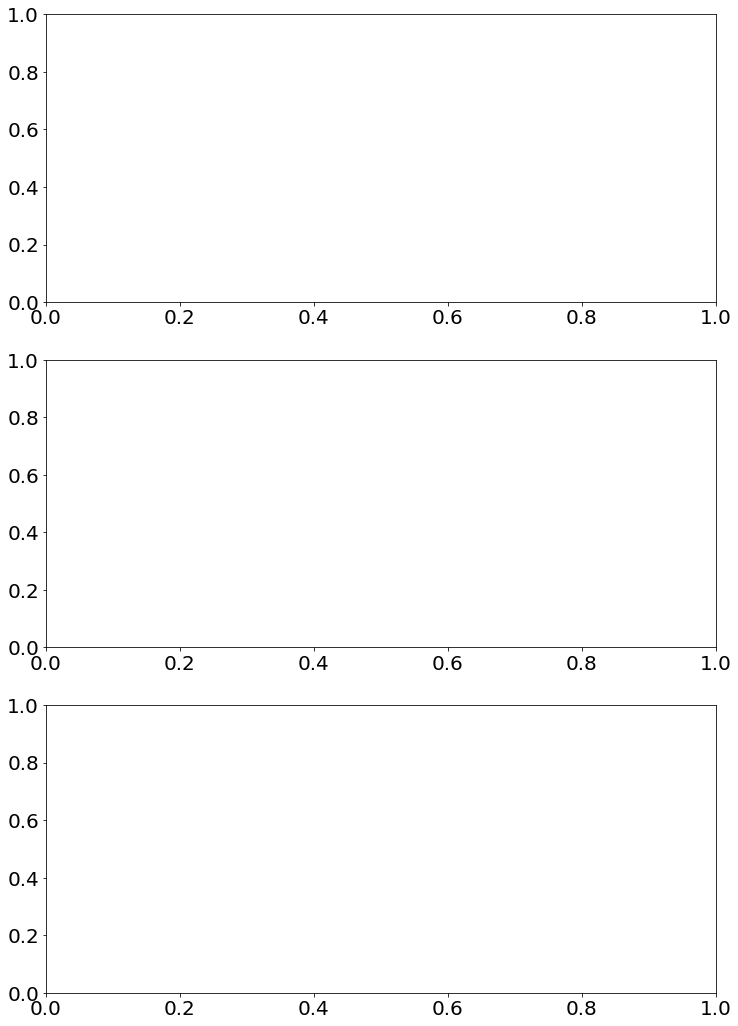

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def plot_all_spectra():
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    
    # ----- Subplot 1: Cs-137 -----
    ax = axs[0]
    ax.plot(x1_cs, y1_cs, label="Cs137 Spectrum, no backing", alpha=0.7, color='green')
    ax.plot(x2_cs, y2_cs, label="Cs137 Spectrum, Pb Backing", alpha=0.7, color='red')
    ax.plot(x3_cs, y3_cs, label="Cs137 Spectrum, Ta Backing", alpha=0.7, color='blue')
    ax.axvline(411, linestyle="--", color="black", alpha=0.6, label="Compton edge, ~411 keV (estimated)")

    ax.set_xlabel("Energy (keV)", fontsize=20)  # Increased by 5 points
    ax.set_ylabel("Counts", fontsize=20)  # Increased by 5 points
    ax.set_title("Cs-137 Spectrum with Gaussian Fits", fontsize=22)  # Increased by 5 points
    ax.set_yscale("linear")
    ax.set_xlim(0, 800)
    ax.legend(loc='upper right', fontsize=13)  # Increased legend font size

    # ----- Subplot 2: Na-22 -----
    ax = axs[1]
    ax.plot(x1_n, y1_n, label="No Backing", alpha=0.7)
    ax.plot(x2_n, y2_n, label="Pb Backing", alpha=0.7)
    ax.plot(x3_n, y3_n, label="Ta Backing", alpha=0.7)

    ax.set_xlabel("Energy (keV)", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    ax.set_title("Na-22 Spectrum with Gaussian Fits", fontsize=22)
    ax.set_yscale("log")
    ax.set_xlim(0, 2000)
    ax.legend(loc='upper right', fontsize=15)

    # ----- Subplot 3: Co-60 -----
    ax = axs[2]
    ax.plot(x2_c, y2_c, label="Spectrum", alpha=0.7)

    ax.set_xlabel("Energy (keV)", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    ax.set_title("Co-60 Spectrum with Gaussian Fits", fontsize=22)
    ax.set_yscale("log")
    ax.set_xlim(0, 2000)
    ax.legend(loc='upper right', fontsize=15)

    plt.tight_layout()
    plt.savefig(r"C:\Users\sarah\Downloads\gamma_spectra.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
    plt.show()

# Call the function
plot_all_spectra()


Peak at 32.0 ± 0.2 keV, FWHM = 18.5 ± 0.6 keV
Peak at 661.9 ± 0.4 keV, FWHM = 67.1 ± 3.2 keV
Gaussian fit failed for peak at 1450.0 keV
Skipping 1470 keV due to low counts


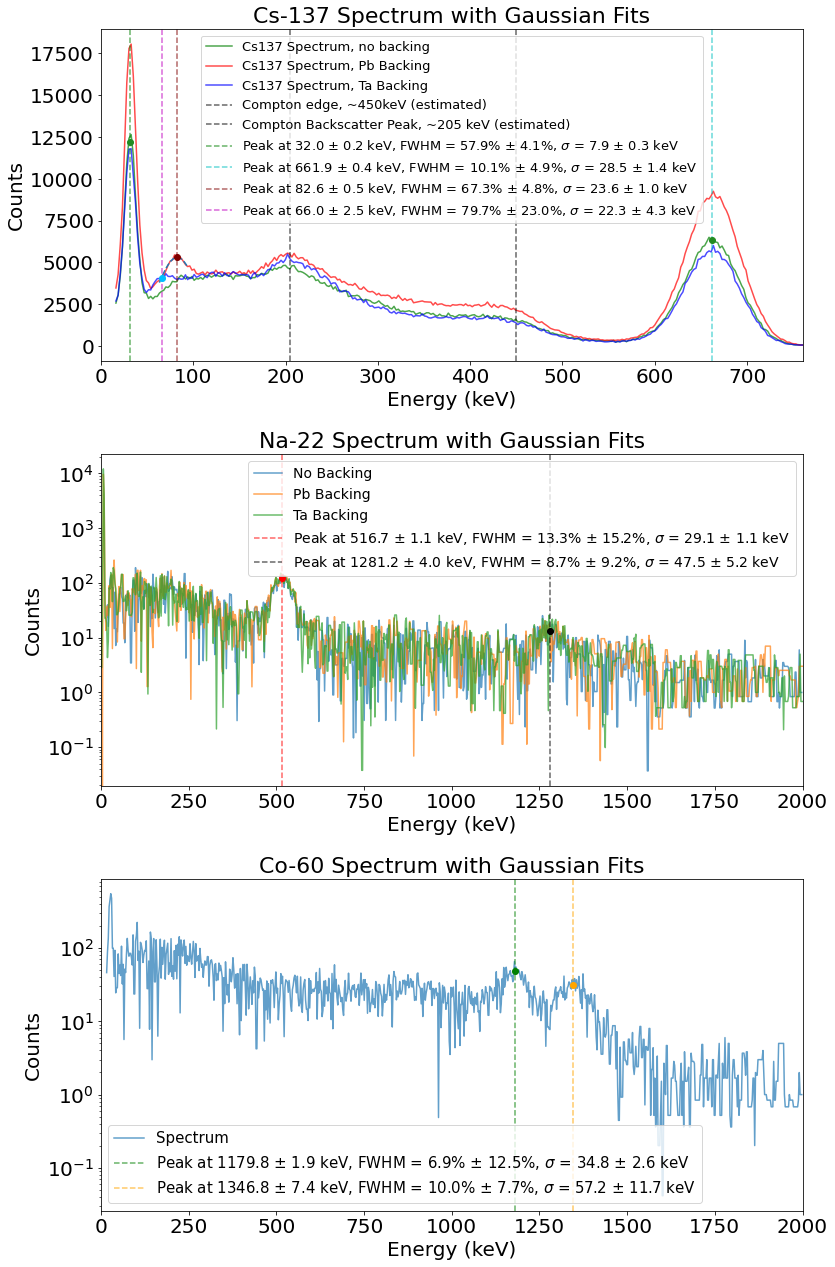

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2)

def plot_all_spectra():
    # ------------- Cs-137 Block -------------
    # (Assumes x1, y1, x2, y2, x3, y3 are defined prior to calling this function.)
    # Truncate data to 2 MeV and avoid low-energy noise:
    mask_cs1 = (x1 > 15) & (x1 < 2000)
    x1_cs = x1[mask_cs1]
    y1_cs = y1[mask_cs1]
    
    mask_cs2 = (x2 > 15) & (x2 < 2000)
    x2_cs = x2[mask_cs2]
    y2_cs = y2[mask_cs2]
    
    mask_cs3 = (x3 > 15) & (x3 < 2000)
    x3_cs = x3[mask_cs3]
    y3_cs = y3[mask_cs3]
    
    # ------------- Na-22 Block -------------
    # Define file paths (update these paths as needed)
    bkg_path   = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\bkg_spec_longtrace.Chn"
    Na_nb_path = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\na22_nobacking_logplt.Chn"
    Na_Pb_path = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Na22_Pbbacking.Chn"
    Na_Ta_path = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Na22_Tabacking_logplt.Chn"
    
    # Load data (read_file should return numpy arrays for x and y)
    x0_n, y0_n = read_file(bkg_path)
    x1_n, y1_n = read_file(Na_nb_path)
    x2_n, y2_n = read_file(Na_Pb_path)
    x3_n, y3_n = read_file(Na_Ta_path)
    
    def smooth(y):
        y = np.array(y, dtype=float)
        for i in range(1, len(y)):
            if y[i] <= 0:
                y[i] = y[i-1]
        return y

    # Normalize and subtract background:
    s1 = 900/902.54
    y1_n = y1_n * s1
    s2 = 900/900
    y2_n = y2_n * s2
    s3 = 900/900.96
    y3_n = y3_n * s3
    s4 = 900/777.7
    y0_n = y0_n * s4
    
    y1_n = smooth(y1_n - y0_n)
    y2_n = smooth(y2_n - y0_n)
    y3_n = smooth(y3_n - y0_n)
    
    # Truncate Na-22 data:
    mask_na = (x1_n > 15) & (x1_n < 2000)
    x1_n = x1_n[mask_na]
    y1_n = y1_n[mask_na]
    
    # ------------- Co-60 Block -------------
    # Define file paths (update these paths as needed)
    Co_bkg_path = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\bkg_spec_longtrace.Chn"
    Co_nb_path  = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Co60_nobacking_shield.Chn"
    Co_Pb_path  = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\co_Pb_backing.Chn"
    Co_Ta_path  = r"C:\Users\sarah\OneDrive\Sp2025\Gates N-0_new\Co60_Tabacking_logplt.Chn"
    
    x0_c, y0_c = read_file(Co_bkg_path)
    x1_c, y1_c = read_file(Co_nb_path)
    x2_c, y2_c = read_file(Co_Pb_path)
    x3_c, y3_c = read_file(Co_Ta_path)
    
    s1c = 900/839.88
    y1_c = y1_c * s1c
    s2c = 900/901.92
    y2_c = y2_c * s2c
    s3c = 900/838.38
    y3_c = y3_c * s3c
    s4c = 900/777.7
    y0_c = y0_c * s4c
    
    y1_c = smooth(y1_c - y0_c)
    y2_c = smooth(y2_c - y0_c)
    y3_c = smooth(y3_c - y0_c)
    
    # Truncate Co-60 data (using the Pb-backed spectrum for fitting)
    mask_c = (x2_c > 15) & (x2_c < 2000)
    x2_c = x2_c[mask_c]
    y2_c = y2_c[mask_c]
    
    # ------------- Create Subplots -------------
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))
    
    # ----- Subplot 1: Cs-137 (Updated) -----
    ax = axs[0]
    # Plot spectra
    ax.plot(x1_cs, y1_cs, label="Cs137 Spectrum, no backing", alpha=0.7, color='green')
    ax.plot(x2_cs, y2_cs, label="Cs137 Spectrum, Pb Backing", alpha=0.7, color='red')
    ax.plot(x3_cs, y3_cs, label="Cs137 Spectrum, Ta Backing", alpha=0.7, color='blue')
    # Compton edge line at 450 keV
    ax.axvline(450, linestyle="--", color="black", alpha=0.6, 
               label="Compton edge, ~450keV (estimated)")
    ax.axvline(205, label = 'Compton Backscatter Peak, ~205 keV (estimated)', linestyle="--", color="black", alpha=0.6)
    ax.set_xlabel("Energy (keV)", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    ax.set_title("Cs-137 Spectrum with Gaussian Fits", fontsize=22)
    ax.set_yscale("linear")
    ax.set_xlim(0, 800)
    
    # --- Fit Gaussians for Cs-137 using the updated code ---
    # Using the "no backing" data (x1_cs, y1_cs)
    energies = x1_cs
    counts = y1_cs
    expected_peaks = [32, 662, 1450]
    fit_range = 7
    colors = ['g', 'c', 'm']
    i = 0
    for peak_energy in expected_peaks:
        peak_index = np.argmin(np.abs(energies - peak_energy))
        x_fit = energies[max(0, peak_index - fit_range): min(len(energies), peak_index + fit_range)]
        y_fit = counts[max(0, peak_index - fit_range): min(len(counts), peak_index + fit_range)]
        if np.max(y_fit) < 10:
            print(f"Skipping {peak_energy:.1f} keV due to low counts")
            continue
        p0 = [max(y_fit), peak_energy, 5]
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            uncertainties = np.sqrt(np.diag(pcov))
            mu_fit = popt[1]
            sigma_fit = popt[2]
            mu_uncertainty = uncertainties[1]
            sigma_uncertainty = uncertainties[2]
            
            # Calculate FWHM and percent width:
            FWHM = 2.355 * sigma_fit
            FWHM_uncertainty = 2.355 * sigma_uncertainty
            FWHM_pc = (FWHM / mu_fit) * 100
            FWHM_pc = round(FWHM_pc, 1)
            FWHM_pc_uncertainty = (mu_uncertainty/mu_fit + FWHM_uncertainty/FWHM) * 100
            FWHM_pc_uncertainty = round(FWHM_pc_uncertainty, 1)
            sigma_fit = round(sigma_fit, 1)
            sfit_uncertainty = round(sigma_uncertainty, 1)
            mu_fit = round(mu_fit, 1)
            mu_uncertainty = round(mu_uncertainty, 1)
            FWHM = round(FWHM, 1)
            FWHM_uncertainty = round(FWHM_uncertainty, 1)
            
            print(f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM} ± {FWHM_uncertainty} keV")
            
            # Mark the peak position on the plot
            ax.axvline(mu_fit, linestyle="--", alpha=0.6, color=colors[i],
                       label=f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM_pc}% ± {FWHM_pc_uncertainty}%, $\\sigma$ = {sigma_fit} ± {sfit_uncertainty} keV")
            ax.scatter(mu_fit, gaussian(mu_fit, *popt), color="forestgreen", zorder=3)
            i += 1
        except RuntimeError:
            print(f"Gaussian fit failed for peak at {peak_energy:.1f} keV")
    
    # Next, the code fits the Pb backing and Ta backing traces.
    # For Pb backing:
    energies = x2_cs
    counts = y2_cs
    expected_peaks = [80]
    fit_range = 7
    for peak_energy in expected_peaks:
        peak_index = np.argmin(np.abs(energies - peak_energy))
        x_fit = energies[max(0, peak_index - fit_range): min(len(energies), peak_index + fit_range)]
        y_fit = counts[max(0, peak_index - fit_range): min(len(counts), peak_index + fit_range)]
        if np.max(y_fit) < 10:
            print(f"Skipping {peak_energy:.1f} keV due to low counts")
            continue
        p0 = [max(y_fit), peak_energy, 7]
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            uncertainties = np.sqrt(np.diag(pcov))
            mu_fit = popt[1]
            sigma_fit = popt[2]
            mu_uncertainty = uncertainties[1]
            sigma_uncertainty = uncertainties[2]
            
            FWHM = 2.355 * sigma_fit
            FWHM_uncertainty = 2.355 * sigma_uncertainty
            FWHM_pc = (FWHM / mu_fit) * 100
            FWHM_pc = round(FWHM_pc, 1)
            FWHM_pc_uncertainty = (mu_uncertainty/mu_fit + FWHM_uncertainty/FWHM) * 100
            FWHM_pc_uncertainty = round(FWHM_pc_uncertainty, 1)
            sigma_fit = round(sigma_fit, 1)
            sfit_uncertainty = round(sigma_uncertainty, 1)
            mu_fit = round(mu_fit, 1)
            mu_uncertainty = round(mu_uncertainty, 1)
            FWHM = round(FWHM, 1)
            FWHM_uncertainty = round(FWHM_uncertainty, 1)
            
            x_smooth = np.linspace(x_fit[0], x_fit[-1], 100)
            ax.plot(x_smooth, gaussian(x_smooth, *popt), linestyle="--")
            ax.axvline(mu_fit, linestyle="--", alpha=0.6, color='maroon',
                       label=f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM_pc}% ± {FWHM_pc_uncertainty}%, $\\sigma$ = {sigma_fit} ± {sfit_uncertainty} keV")
            ax.scatter(mu_fit, gaussian(mu_fit, *popt), color="maroon", zorder=3)
        except RuntimeError:
            print(f"Gaussian fit failed for peak at {peak_energy:.1f} keV")
    
    # For Ta backing:
    energies = x3_cs
    counts = y3_cs
    expected_peaks = [60]
    fit_range = 4
    for peak_energy in expected_peaks:
        peak_index = np.argmin(np.abs(energies - peak_energy))
        x_fit = energies[max(0, peak_index - fit_range): min(len(energies), peak_index + fit_range)]
        y_fit = counts[max(0, peak_index - fit_range): min(len(counts), peak_index + fit_range)]
        if np.max(y_fit) < 10:
            print(f"Skipping {peak_energy:.1f} keV due to low counts")
            continue
        p0 = [max(y_fit), peak_energy, 5]
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            uncertainties = np.sqrt(np.diag(pcov))
            mu_fit = popt[1]
            sigma_fit = popt[2]
            mu_uncertainty = uncertainties[1]
            sigma_uncertainty = uncertainties[2]
            
            FWHM = 2.355 * sigma_fit
            FWHM_uncertainty = 2.355 * sigma_uncertainty
            FWHM_pc = (FWHM / mu_fit) * 100
            FWHM_pc = round(FWHM_pc, 1)
            FWHM_pc_uncertainty = (mu_uncertainty/mu_fit + FWHM_uncertainty/FWHM) * 100
            FWHM_pc_uncertainty = round(FWHM_pc_uncertainty, 1)
            sigma_fit = round(sigma_fit, 1)
            sfit_uncertainty = round(sigma_uncertainty, 1)
            mu_fit = round(mu_fit, 1)
            mu_uncertainty = round(mu_uncertainty, 1)
            FWHM = round(FWHM, 1)
            FWHM_uncertainty = round(FWHM_uncertainty, 1)
            
            # Mark peak position on the Ta backing trace
            ax.axvline(mu_fit, linestyle="--", alpha=0.6, color=colors[i],
                       label=f"Peak at {mu_fit} ± {mu_uncertainty} keV, FWHM = {FWHM_pc}% ± {FWHM_pc_uncertainty}%, $\\sigma$ = {sigma_fit} ± {sfit_uncertainty} keV")
            ax.scatter(mu_fit, gaussian(mu_fit, *popt), color="deepskyblue", zorder=3)
            i += 1
        except RuntimeError:
            print(f"Gaussian fit failed for peak at {peak_energy:.1f} keV")
    ax.set_xlim(0, 760)
    ax.legend(loc='upper center', fontsize=13)
    
    # ----- Subplot 2: Na-22 -----
    ax = axs[1]
    # Plot spectra
    ax.plot(x1_n, y1_n, label="No Backing", alpha=0.7)
    ax.plot(x2_n, y2_n, label="Pb Backing", alpha=0.7)
    ax.plot(x3_n, y3_n, label="Ta Backing", alpha=0.7)
    ax.set_xlabel("Energy (keV)", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    ax.set_title("Na-22 Spectrum with Gaussian Fits", fontsize=22)
    
    # Fit Gaussians for expected Na-22 peaks (using the Pb-backed spectrum for fitting)
    expected_peaks_na = [511, 1274, 1470]
    fit_range = 30
    na_colors = ['r', 'k', 'magenta']
    for i, peak in enumerate(expected_peaks_na):
        idx = np.argmin(np.abs(x2_n - peak))
        x_fit = x2_n[max(0, idx - fit_range): min(len(x2_n), idx + fit_range)]
        y_fit = y2_n[max(0, idx - fit_range): min(len(y2_n), idx + fit_range)]
        if np.max(y_fit) < 10:
            print(f"Skipping {peak} keV due to low counts")
            continue
        p0 = [max(y_fit), peak, 5]
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            uncert = np.sqrt(np.diag(pcov))
            mu_fit = round(popt[1], 1)
            mu_unc = round(uncert[1], 1)
            FWHM = 2.355 * popt[2]
            FWHM_pc = round((FWHM / popt[1]) * 100, 1)
            FWHM_pc_uncertainty = (mu_uncertainty/mu_fit + FWHM_uncertainty/FWHM) * 100
            FWHM_pc_uncertainty = round(FWHM_pc_uncertainty, 1)
            sigma_fit = round(popt[2], 1)
            sfit_uncertainty = round(uncert[2], 1)
            ax.axvline(mu_fit, linestyle="--", color=na_colors[i % len(na_colors)], alpha=0.6,
                       label=f"Peak at {mu_fit} ± {mu_unc} keV, FWHM = {FWHM_pc}% ± {FWHM_pc_uncertainty}%, $\\sigma$ = {sigma_fit} ± {sfit_uncertainty} keV")
            ax.scatter(mu_fit, gaussian(mu_fit, *popt),
                       color=na_colors[i % len(na_colors)], zorder=3)
        except RuntimeError:
            print(f"Gaussian fit failed for {peak} keV")
    ax.set_yscale("log")
    ax.set_xlim(0, 2000)
    ax.legend(loc='upper right', fontsize=14)
    
    # ----- Subplot 3: Co-60 -----
    ax = axs[2]
    # Plot the Pb-backed Co-60 spectrum (for example)
    ax.plot(x2_c, y2_c, label="Spectrum", alpha=0.7)
    ax.set_xlabel("Energy (keV)", fontsize=20)
    ax.set_ylabel("Counts", fontsize=20)
    ax.set_title("Co-60 Spectrum with Gaussian Fits", fontsize=22)
    
    # Fit Gaussians for expected Co-60 peaks
    expected_peaks_co = [1186, 1332.5]
    fit_range = 20
    co_colors = ['g', 'orange']
    for i, peak in enumerate(expected_peaks_co):
        idx = np.argmin(np.abs(x2_c - peak))
        x_fit = x2_c[max(0, idx - fit_range): min(len(x2_c), idx + fit_range)]
        y_fit = y2_c[max(0, idx - fit_range): min(len(y2_c), idx + fit_range)]
        if np.max(y_fit) < 10:
            print(f"Skipping {peak} keV due to low counts")
            continue
        p0 = [max(y_fit), peak, 5]
        try:
            popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=p0)
            uncert = np.sqrt(np.diag(pcov))
            mu_fit = round(popt[1], 1)
            mu_unc = round(uncert[1], 1)
            FWHM = 2.355 * popt[2]
            FWHM_pc = round((FWHM / popt[1]) * 100, 1)
            FWHM_pc_uncertainty = (mu_uncertainty/mu_fit + FWHM_uncertainty/FWHM) * 100
            FWHM_pc_uncertainty = round(FWHM_pc_uncertainty, 1)
            sigma_fit = round(popt[2], 1)
            sfit_uncertainty = round(uncert[2], 1)
            ax.axvline(mu_fit, linestyle="--", color=co_colors[i], alpha=0.6,
                       label=f"Peak at {mu_fit} ± {mu_unc} keV, FWHM = {FWHM_pc}% ± {FWHM_pc_uncertainty}%, $\\sigma$ = {sigma_fit} ± {sfit_uncertainty} keV")
            ax.scatter(mu_fit, gaussian(mu_fit, *popt), color=co_colors[i], zorder=3)
        except RuntimeError:
            print(f"Gaussian fit failed for {peak} keV")
    ax.set_yscale("log")
    ax.set_xlim(0, 2000)
    ax.legend(loc='lower left', fontsize=15)
    
    plt.tight_layout()
    plt.savefig(r"C:\Users\sarah\Downloads\gamma_spectra.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
    plt.show()

# To run the function, ensure that:
# 1. The Cs-137 arrays (x1, y1, x2, y2, x3, y3) are already defined.
# 2. The read_file function is defined and working.
#
# Then simply call:
plot_all_spectra()
